In [1]:
import numpy as np
import torch
import dgl

from rdkit import Chem
from rdkit.Chem import AllChem

from tdc.single_pred import ADME

Using backend: pytorch[12:56:19] /opt/dgl/src/runtime/tensordispatch.cc
:43: TensorDispatcher: dlopen failed: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory


# Molecular Graph Practice

# 1. Download datasets from therapeutic Data Commonds (TDC)

In [2]:
dataset = ADME(name='Solubility_AqSolDB')

Found local copy...
Loading...
Done!


In [3]:
split = dataset.get_split(
    method='random',
    seed=999,
    frac=[0.7, 0.1, 0.2],
)

In [4]:
train_set = split['train']
valid_set = split['valid']
test_set = split['test']

In [5]:
train_set

,Drug_ID,Drug,Y
0,"N,N,N-trimethyloctadecan-1-aminium bromide",CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],-3.616127
1,4-chlorobenzaldehyde,O=Cc1ccc(Cl)cc1,-2.177078
2,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,-3.924409
3,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,-4.662065
4,vinyltoluene,C=Cc1cccc(C)c1,-3.123150
...,...,...,...
6983,sulfamethazine,Cc1cc(C)nc(NS(=O)(=O)c2ccc(N)cc2)n1,-2.730000
6984,sulfasalazine,O=C(O)c1cc(/N=N/c2ccc(S(=O)(=O)Nc3ccccn3)cc2)c...,-6.140000
6985,tetracaine,CCCCNc1ccc(C(=O)OCCN(C)C)cc1,-3.010000
6986,tetracycline,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,-2.930000


In [6]:
smi_train = list(train_set['Drug'])
label_train = list(train_set['Y'])

In [7]:
smi_train[0]

'CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-]'

In [8]:
label_train[0]

-3.6161271205

# 2. Visualize molecules

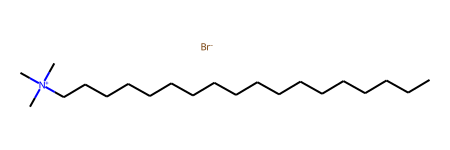

In [9]:
mol = Chem.MolFromSmiles(smi_train[0])
mol

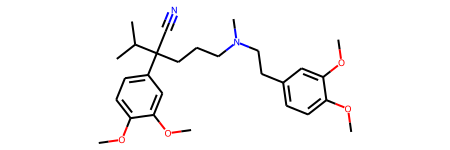

In [10]:
mol = Chem.MolFromSmiles(smi_train[-1])
mol

# 3. Investiagate how can we featurize molecular structure

## 1) Atom (node) features 
* Atom symbol -- ex) carbon: C, oxygen: O
* Atom degree
* Number of hydrogens attatched to a given atom (implicit hydrogen model)
* Implicit valence 
* Whether a given atom has an aromatic character or not

In [11]:
atom_list = mol.GetAtoms()
num_atoms = len(atom_list)
num_atoms

33

In [12]:
atom_ = atom_list[0]

In [13]:
atom_

In [14]:
atom_.GetSymbol()

'C'

In [15]:
atom_.GetDegree()

1

In [16]:
atom_.GetTotalNumHs()

3

In [17]:
atom_.GetImplicitValence()

3

In [18]:
atom_.GetIsAromatic()

False

## 1) Bond (edge) features 
* Bond types -- Single, Double, Triple, Aromatic
* Whether a given bond is conjugated or not
* Whether a given bond has a ring character

In [19]:
bond_list = mol.GetBonds()
num_bonds = len(bond_list)
num_bonds

34

In [20]:
bond_ = bond_list[0]

In [21]:
bond_.GetBondType()

rdkit.Chem.rdchem.BondType.SINGLE

In [22]:
bond_.GetIsConjugated()

False

In [23]:
bond_.IsInRing()

False

# 4. Put them altogether -- define a series of functions that featurize molecular graph

In [24]:
# GLOBAL VARIABLE
ATOM_VOCAB = [
    'C', 'N', 'O', 'S', 'F',
    'H', 'Si', 'P', 'Cl', 'Br',
    'Li', 'Na', 'K', 'Mg', 'Ca',
    'Fe', 'As', 'Al', 'I', 'B',
    'V', 'Tl', 'Sb', 'Sn', 'Ag',
    'Pd', 'Co', 'Se', 'Ti', 'Zn',
    'Ge', 'Cu', 'Au', 'Ni', 'Cd',
    'Mn', 'Cr', 'Pt', 'Hg', 'Pb',
]

In [25]:
def one_of_k_encoding(x, vocab):
    if x not in vocab:
        x = vocab[-1]
    return list(map(lambda s: float(x==s), vocab))

In [26]:
def get_atom_feature(atom):
    atom_feature = one_of_k_encoding(atom.GetSymbol(), ATOM_VOCAB)
    atom_feature += one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5])
    atom_feature += one_of_k_encoding(atom.GetTotalNumHs(), [0, 1, 2, 3, 4])
    atom_feature += one_of_k_encoding(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5])
    atom_feature += [atom.GetIsAromatic()]
    return atom_feature

In [27]:
def get_bond_feature(bond):
    bt = bond.GetBondType()
    bond_feature = [
        bt == Chem.rdchem.BondType.SINGLE,
        bt == Chem.rdchem.BondType.DOUBLE,
        bt == Chem.rdchem.BondType.TRIPLE,
        bt == Chem.rdchem.BondType.AROMATIC,
        bond.GetIsConjugated(),
        bond.IsInRing()
    ]
    return bond_feature

In [28]:
def get_molecular_graph(smi):
    mol = Chem.MolFromSmiles(smi)
    graph = dgl.DGLGraph()
    
    atom_list = mol.GetAtoms()
    num_atoms = len(atom_list)
    graph.add_nodes(num_atoms)
    
    atom_feature_list = [get_atom_feature(atom) for atom in atom_list]
    atom_feature_list = torch.tensor(atom_feature_list, dtype=torch.float64)
    graph.ndata['h'] = atom_feature_list
 
    bond_list = mol.GetBonds()
    bond_feature_list = []
    for bond in bond_list:
        bond_feature = get_bond_feature(bond)
        
        src = bond.GetBeginAtom().GetIdx()
        dst = bond.GetEndAtom().GetIdx()
 
        # DGL graph is undirectional
        # Thus, we have to add edge pair of both (i,j) and (j, i)
        # i --> j
        graph.add_edges(src, dst)
        bond_feature_list.append(bond_feature)

        # j --> i
        graph.add_edges(dst, src)
        bond_feature_list.append(bond_feature)

    bond_feature_list = torch.tensor(bond_feature_list, dtype=torch.float64)
    graph.edata['e_ij'] = bond_feature_list
    return graph

In [29]:
smi_ = smi_train[-1]
g_ = get_molecular_graph(smi_)

In [30]:
g_

Graph(num_nodes=33, num_edges=68,
      ndata_schemes={'h': Scheme(shape=(58,), dtype=torch.float64)}
      edata_schemes={'e_ij': Scheme(shape=(6,), dtype=torch.float64)})

In [31]:
g_.ndata['h']

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

In [32]:
g_.ndata['h'].shape

torch.Size([33, 58])

In [33]:
g_.edata['e_ij']

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0

In [34]:
g_.edata['e_ij'].shape

torch.Size([68, 6])

# GNN Practice

# 1. GCN, GIN and GIN+E

In [35]:
import torch.nn as nn 
import torch.nn.functional as F

import dgl.function as fn
from dgl.nn.functional import edge_softmax

In [38]:
h0 = g_.ndata['h'].float()
embedding_node = nn.Linear(58, 64, bias=False)
embedding_edge = nn.Linear(6, 64, bias=False)
h0 = embedding_node(h0)
g_.ndata['h'] = h0
h0

tensor([[-0.0074, -0.2408,  0.2086,  ..., -0.2388, -0.0149, -0.0177],
        [-0.1628,  0.0205,  0.0198,  ..., -0.0343,  0.0858, -0.3845],
        [-0.0555, -0.2638,  0.2622,  ...,  0.1037,  0.1383, -0.0746],
        ...,
        [-0.0555, -0.2638,  0.2622,  ...,  0.1037,  0.1383, -0.0746],
        [-0.1628,  0.0205,  0.0198,  ..., -0.0343,  0.0858, -0.3845],
        [-0.0074, -0.2408,  0.2086,  ..., -0.2388, -0.0149, -0.0177]],
       grad_fn=<MmBackward>)

In [39]:
h0.shape

torch.Size([33, 64])

In [40]:
e_ij = embedding_edge(g_.edata['e_ij'].float())
g_.edata['e_ij'] = e_ij

In [41]:
e_ij.shape

torch.Size([68, 64])

## 1) Graph Convolution

$ h_{i}^{(l+1)} = \sigma (W^{(l+1)} \sum_{j \in N(i)} h_{j}^{(l)})$

### u_ : sum aggregation of the adjacent node features 

In [42]:
g_.update_all(fn.copy_u('h', 'm'), fn.sum('m', 'u_'))

In [43]:
u_ = g_.ndata['u_']
u_

tensor([[-0.1628,  0.0205,  0.0198,  ..., -0.0343,  0.0858, -0.3845],
        [-0.0629, -0.5046,  0.4708,  ..., -0.1351,  0.1234, -0.0923],
        [-0.3833, -0.4679,  0.4130,  ..., -0.1529,  0.1644, -0.7081],
        ...,
        [-0.3833, -0.4679,  0.4130,  ..., -0.1529,  0.1644, -0.7081],
        [-0.0629, -0.5046,  0.4708,  ..., -0.1351,  0.1234, -0.0923],
        [-0.1628,  0.0205,  0.0198,  ..., -0.0343,  0.0858, -0.3845]],
       grad_fn=<GSpMMBackward>)

In [44]:
u_.shape

torch.Size([33, 64])

In [45]:
g_.ndata['u_'].shape

torch.Size([33, 64])

### Applying linear layer, non-linear activation, layer normalization, and dropout

In [46]:
linear_ = nn.Linear(64, 64, bias=False)
norm_ = nn.LayerNorm(64)
act_ = F.relu
prob_ = 0.2

In [47]:
h_ = linear_(u_)

In [48]:
h_ = act_(h_) + h0 # non-linear activation (ReLU) and skip-connection

In [49]:
h_ = norm_(h_)

In [50]:
h_ = F.dropout(h_, p=prob_, training=False)

In [51]:
# g_.ndata['h'] = h_ <-- update node feature, 
# but it will be omitted in this practice because we have to keep practice other GNN layers

## 2) Graph Isomorphism

$ h_{i}^{(l+1)} = \sigma (\text{MLP}^{(l+1)} (\sum_{j \in N(i)} h_{j}^{(l)})) $

In [52]:
class MLP(nn.Module):
    def __init__(
        self,
        input_dim,
        hidden_dim,
        output_dim,
        bias=True,
        act=F.relu,
    ):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.act = act

        self.linear1 = nn.Linear(input_dim, hidden_dim, bias=bias)
        self.linear2 = nn.Linear(hidden_dim, output_dim, bias=bias)

    def forward(self, h):
        h = self.linear1(h)
        h = self.act(h)
        h = self.linear2(h)
        return h

### u_ : sum aggregation of the adjacent node features, same as GCN practice

In [53]:
g_.update_all(fn.copy_u('h', 'm'), fn.sum('m', 'u_'))
u_ = g_.ndata['u_']
u_.shape

torch.Size([33, 64])

In [54]:
### Applying linear layer, non-linear activation, layer normalization, and dropout

In [55]:
mlp_ = MLP(
    input_dim=64, 
    hidden_dim=64*4, 
    output_dim=64,
)
norm_ = nn.LayerNorm(64)
act_ = F.relu
prob_ = 0.2

In [56]:
h_ = mlp_(u_)
h_ = act_(h_) + h0 # non-linear activation (ReLU) and skip-connection
h_ = norm_(h_)
h_ = F.dropout(h_, p=prob_, training=False)

In [57]:
# g_.ndata['h'] = h_ <-- update node feature, 
# but it will be omitted in this practice because we have to keep practice other GNN layers

## 3) Graph Isomorphism w/ edge features

$ h_{i}^{(l+1)} = \sigma (\text{MLP}^{(l+1)} (\sum_{j \in N(i)} h_{j}^{(l)} + e_{ij}^{(l)})) $

### u_ : sum aggregation of the adjacent node features, same as GCN practice
### e_ : sum aggregation of the edges connected to the center atoms

In [58]:
g_.update_all(fn.copy_u('h', 'm'), fn.sum('m', 'u_'))
u_ = g_.ndata['u_']
u_.shape

torch.Size([33, 64])

In [59]:
g_.update_all(fn.copy_edge('e_ij', 'm_e'), fn.sum('m_e', 'e_'))
e_ = g_.ndata['e_']
e_.shape

torch.Size([33, 64])

In [61]:
h_ = g_.ndata['u_'] + g_.ndata['e_']

In [62]:
h_ = mlp_(u_)
h_ = act_(h_) + h0 # non-linear activation (ReLU) and skip-connection
h_ = norm_(h_)
h_ = F.dropout(h_, p=prob_, training=False)

In [63]:
h_.shape

torch.Size([33, 64])